In [1]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install accelerate
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import torch
from transformers import AutoTokenizer, TrainingArguments, Trainer, pipeline, DefaultDataCollator, AutoModelForQuestionAnswering
import tqdm
import json
from torch.utils.data import DataLoader, random_split
from datasets import Dataset, load_dataset, DatasetDict
import optuna
from google.colab import drive
drive.mount('/content/drive')
from huggingface_hub import notebook_login

Mounted at /content/drive


In [ ]:
# Login into HuggingFace to Host the Tuned Bot
notebook_login()

In [5]:
# Load and Concatenate Datasets
squad_df = pd.concat([pd.read_json('/content/drive/MyDrive/Code/train-v1.1.json'), pd.read_json('/content/drive/MyDrive/Code/dev-v1.1.json')]).drop(columns=["version"]).reset_index()

squad_df.head()

,index,data
0,0,"{'title': 'University_of_Notre_Dame', 'paragra..."
1,1,"{'title': 'Beyoncé', 'paragraphs': [{'context'..."
2,2,"{'title': 'Montana', 'paragraphs': [{'context'..."
3,3,"{'title': 'Genocide', 'paragraphs': [{'context..."
4,4,"{'title': 'Antibiotics', 'paragraphs': [{'cont..."


# Data Pre-Processing

In [6]:
# Separate the Data into "TEXT", "QUESTION", "ANSWER"
text = list()
question = list()
answer = list()
answer_start = list()
answer_end = list()
ids = list()

for element in squad_df['data']:
  for paragraph in element['paragraphs']:
    context = paragraph['context']
    for qa in paragraph['qas']:
      quest = qa['question']
      id = qa['id']
      for ans in qa['answers']:
        text.append(context.strip())
        question.append(quest.strip())
        answer.append(ans['text'].strip())
        answer_start.append(ans['answer_start'])
        answer_end.append(ans['answer_start'] + len(ans['text']) - 1)
        ids.append(id)

qa_df = pd.DataFrame(zip(text, question, answer, answer_start, answer_end, ids), columns=['TEXT', 'QUESTION', 'ANSWER', 'BOS', 'EOS', 'ID'])
qa_df.head()

,TEXT,QUESTION,ANSWER,BOS,EOS,ID
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous,515,540,5733be284776f41900661182
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ,188,212,5733be284776f4190066117f
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building,279,295,5733be284776f41900661180
3,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,a Marian place of prayer and reflection,381,419,5733be284776f41900661181
4,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary,92,125,5733be284776f4190066117e


In [7]:
print(f'Original Total Entries: {len(qa_df)}')
print(f'Pruned Indentical Entries New Total: {len(qa_df.drop_duplicates())}')

# Drop Duplicates
original_qa_df = qa_df.drop_duplicates()
original_qa_df.head()

Original Total Entries: 122325
Pruned Indentical Entries New Total: 105815


,TEXT,QUESTION,ANSWER,BOS,EOS,ID
0,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous,515,540,5733be284776f41900661182
1,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ,188,212,5733be284776f4190066117f
2,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building,279,295,5733be284776f41900661180
3,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,a Marian place of prayer and reflection,381,419,5733be284776f41900661181
4,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary,92,125,5733be284776f4190066117e


In [8]:
# Determine the Average Length of the Context
# Check Length of Reviews
fig = px.histogram([len(context.split()) for context in original_qa_df['TEXT']], title='Context Length')
fig.show()

In [9]:
# Get Info on Length of Context
pd.Series([len(context.split()) for context in original_qa_df['TEXT']]).describe()

count    105815.000000
mean        120.542447
std          50.648448
min          20.000000
25%          89.000000
50%         110.000000
75%         143.000000
max         653.000000
dtype: float64

In [10]:
# Get Third Standard Deviatio of Context Length
print(f"3rd STD DEV for Context Length: {np.mean([len(context.split()) for context in original_qa_df['TEXT']]) + 3 * np.std([len(context.split()) for context in original_qa_df['TEXT']])}")

3rd STD DEV for Context Length: 272.4870733757692


In [11]:
# Create a Dataset Object to Hold the Information Necessary to be Used in Training the Model
ds = Dataset.from_dict({"context": original_qa_df['TEXT'].to_list(), "question": original_qa_df["QUESTION"].to_list(), "answer_start": original_qa_df["BOS"].to_list(), "answer_end": original_qa_df["EOS"].to_list(), "answer": original_qa_df['ANSWER'].to_list(), "id":original_qa_df['ID'].to_list()})

# Save Dataset as CSV
ds.to_csv('qa.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/106 [00:00<?, ?ba/s]

93059269

In [13]:
# Load the Saved Dataset (Taking a Subset to Speed Up Training)
raw_dataset = load_dataset('csv', data_files='/content/qa.csv', split="train[:10000]")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [14]:
# Sanity Check the Dataset
raw_dataset

Dataset({
    features: ['context', 'question', 'answer_start', 'answer_end', 'answer', 'id'],
    num_rows: 10000
})

In [15]:
# Split the dataset into train and test sets
initial_dataset = raw_dataset.train_test_split(
    test_size=0.2, # The Test of the Dataset will Serve as the Actual Test Set For Evaluation
    shuffle=True,
    seed=42
)


# Split the train dataset (containng 8000 instances) into train and validation sets
final_dataset = initial_dataset['train'].train_test_split(
    test_size=0.25, # The Test Set will be the Validation Set During Training
    shuffle=True,
    seed=42
)

# Create a dictionary to store the datasets with keys
dataset_dict = {
    "train": final_dataset['train'],
    "test": initial_dataset['test'],
    "validation": final_dataset['test']
}

# Convert the dictionary to a Dataset object
train_test_split_data = DatasetDict(dataset_dict)

train_test_split_data

DatasetDict({
    train: Dataset({
        features: ['context', 'question', 'answer_start', 'answer_end', 'answer', 'id'],
        num_rows: 6000
    })
    test: Dataset({
        features: ['context', 'question', 'answer_start', 'answer_end', 'answer', 'id'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['context', 'question', 'answer_start', 'answer_end', 'answer', 'id'],
        num_rows: 2000
    })
})

# Text Preprocessing

In [16]:
# Load the Model to Perform Fine-Tuning on, DistilBERT was Chosen for Reduction in Parameters, To Speed Up Training
# MultiLingual Was Chosen to Handle Questions in Multiple Languages Given an English Context
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")

Following Training Code was Influenced By:

Hugging Face. (2023, October 13). Task - Question Answering. https://huggingface.co/docs/transformers/tasks/question_answering

In [17]:
# Test the Tokenizer on the First 10 Questions in the Overall Dataset (Not the Train, Validation, Test)
examples = raw_dataset[:10]

inputs = tokenizer(
        examples['question'],
        examples["context"],
        max_length=275,
        truncation="only_second",
        return_offsets_mapping=True,
        return_overflowing_tokens=True,
        padding="max_length",
        stride=50
)


In [18]:
print(f"The 10 examples gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")

The 10 examples gave 15 features.
Here is where each comes from: [0, 1, 2, 3, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9].


In [19]:
# Check the Decoded Tokenizer for the First 10 Queries in the Overall Dataset
for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive ( and in a direct line that connects through 3 statues and the Gold Dome ), is a simple, modern stone statue of Mary. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [20]:
examples = raw_dataset[:10]

start_positions = []
end_positions = []

# Loop through the first 10 elements of the "offset_mapping" list and their corresponding answers
for i, offset in enumerate(inputs["offset_mapping"][:10]):
    answer = examples['answer'][i]       # Get the answer for the current example
    start_char = examples['answer_start'][i]  # Get the starting character position of the answer
    end_char = examples['answer_end'][i]      # Get the ending character position of the answer
    sequence_ids = inputs.sequence_ids(i)     # Get the sequence IDs for the current example

    # Find the start and end of the context in the sequence_ids
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx  # The index where the context begins

    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1  # The index where the context ends

    # If the answer is not fully inside the context, label it as (0, 0)
    if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
        start_positions.append(0)  # Start position is set to 0
        end_positions.append(0)    # End position is set to 0
    else:
        # Otherwise, determine the start and end token positions of the answer
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)  # Store the start token position

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)  # Store the end token position

In [21]:
# Extract a Test Sample to Ensure the Answer is Being Extracted as Expected Given the BOS and EOS Positions
idx = 1
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = examples["answer"][sample_idx]

start = start_positions[idx]
end = end_positions[idx]
labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])

print(f"Expected answer: {answer}, BOS and EOS give: {labeled_answer}")

Expected answer: a copper statue of Christ, BOS and EOS give: a copper statue of Christ


In [22]:
def preprocess_function(examples):
  """
  Preprocesses a batch of examples for question answering using a tokenizer and returns the processed inputs.

  Args:
      examples (dict): A dictionary containing input examples with keys 'question', 'context', 'answer', 'answer_start', and 'answer_end'.

  Returns:
      dict: Processed inputs for question answering, including 'input_ids', 'attention_mask', 'start_positions', and 'end_positions'.
  """

  # Tokenize the batch of questions and contexts with certain settings
  inputs = tokenizer(
    examples['question'],
    examples["context"],
    max_length=275,                # Maximum total input length
    truncation="only_second",      # Truncate the second part (context) if it exceeds max_length
    return_offsets_mapping=True,   # Retrieve character offsets for tokens
    padding="max_length",          # Pad to the specified max_length
    stride=50  # Specify the value for stride here if needed
  )

  # Lists to Store the BOS and EOS Tokens
  start_positions = []
  end_positions = []

  # Iterate through offset mappings and examples to extract token positions for the batch
  for i, offset in enumerate(inputs["offset_mapping"]):
    answer = examples['answer'][i]
    start_char = examples['answer_start'][i]
    end_char = examples['answer_end'][i]
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context in the sequence_ids
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label it (0, 0)
    if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
      start_positions.append(0)
      end_positions.append(0)
    else:
      # Otherwise, determine the start and end token positions
      idx = context_start
      while idx <= context_end and offset[idx][0] <= start_char:
        idx += 1
      start_positions.append(idx - 1)

      idx = context_end
      while idx >= context_start and offset[idx][1] >= end_char:
        idx -= 1
      end_positions.append(idx + 1)

  # Add start_positions and end_positions to the inputs
  inputs["start_positions"] = start_positions
  inputs["end_positions"] = end_positions

  return inputs

In [23]:
# Tokenizer the Training Data
train_dataset = train_test_split_data["train"].map(
    preprocess_function,
    batched=True,
    remove_columns=train_test_split_data["train"].column_names,
)
len(train_test_split_data["train"]), len(train_dataset)


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

(6000, 6000)

In [24]:
# Tokenize the Validation Data
validation_dataset = train_test_split_data["validation"].map(
    preprocess_function,
    batched=True,
    remove_columns=train_test_split_data["validation"].column_names,
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

# Fine - Tune (Train) the Model

In [25]:
# Define a data collator for processing and batching training data
data_collator = DefaultDataCollator()

In [26]:
# Load the Model to Perform Fine-Tuning on, DistilBERT was Chosen for Reduction in Parameters
# MultiLingual Was Chosen to Handle Questions in Multiple Languages Given an English Context
model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-multilingual-cased")

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Empty Cache to Ensure Enough Memory is Available for Training
torch.cuda.empty_cache()

In [28]:

validation_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'start_positions', 'end_positions'],
    num_rows: 2000
})

In [ ]:
def custom_compute_f1_score(predictions, references):
    # Implement F1 Score calculation based on your specific format
    # This depends on how you represent predictions and references.
    f1_scores = []

    start_p = predictions[0]
    end_p = predictions[1]

    start_r = references['start_positions']
    end_r = references['end_positions']

    for input_id, bos_p, eos_p, bos_r, eos_r in zip(references['input_ids'], start_p, end_p, start_r, end_r):
        # Tokenize the prediction and reference into tokens
        prediction_tokens = input_id[bos_p : eos_p + 1]

        reference_tokens = input_id[bos_r : eos_r + 1]


        common_tokens = set(prediction_tokens) & set(reference_tokens)

        if not common_tokens:
            f1 = 0.0
            f1_scores.append(f1)
            continue

        # Calculate precision, recall, and F1
        precision = len(common_tokens) / len(prediction_tokens)
        recall = len(common_tokens) / len(reference_tokens)

        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)

        f1_scores.append(f1)

    return sum(f1_scores) / len(f1_scores)

def custom_compute_em_score(predictions, references):
    # Implement Exact Match (EM) Score calculation based on your specific format.
    em_scores = []

    start_p = predictions[0]
    end_p = predictions[1]

    start_r = references['start_positions']
    end_r = references['end_positions']

    for input_id, bos_p, eos_p, bos_r, eos_r in zip(references['input_ids'], start_p, end_p, start_r, end_r):
        prediction = tokenizer.decode(input_id[bos_p : eos_p + 1])

        reference = tokenizer.decode(input_id[bos_r : eos_r + 1])

        # Check if the prediction exactly matches the reference
        em_score = 1 if prediction == reference else 0

        em_scores.append(em_score)

    return sum(em_scores) / len(em_scores)

In [ ]:
# HyperParameter Training
def objective(trial, model, train_data, val_data):
  '''
  Function to Perform HyperaParameter Tuning on the ChatBot
  '''
  # Define the training arguments
  training_args = TrainingArguments(
    output_dir="./ChatterBotQA",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    per_device_train_batch_size=trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
    per_device_eval_batch_size=16,
    num_train_epochs=trial.suggest_int("num_train_epochs", 2, 4),
    learning_rate=trial.suggest_float("learning_rate", 1e-5, 2e-5),
    )

  # Create and fine-tune the model
  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    )

  trainer.train()

  # Make predictions on the validation dataset
  predictions = trainer.predict(val_data)

  print(np.argmax(predictions.predictions, axis=-1))

  # Calculate F1 Score and EM Score based on predictions and input_ids
  f1_score = custom_compute_f1_score(np.argmax(predictions.predictions, axis=-1), val_data)
  em_score = custom_compute_em_score(np.argmax(predictions.predictions, axis=-1), val_data)

  # Print or log intermediate evaluation results
  print(f"Intermediate F1 Score: {f1_score}")
  print(f"Intermediate EM Score: {em_score}")

  # Return the F1 Score for Optuna optimization
  return f1_score

######## Uncomment Below to Perform HyperParameter Training: WARNING ~2HRs w/ GPU ################
# Create an Optuna study
# study = optuna.create_study(direction="maximize")

# Optimize the hyperparameters
# study.optimize(lambda trial: objective(trial, model, train_dataset, validation_dataset), n_trials=10)

# Print the best hyperparameters and their corresponding F1-score
# best_params = study.best_params
# best_f1 = study.best_value
# print("Best Hyperparameters:", best_params)
# print("Best F1-score:", best_f1)

[I 2023-10-16 02:29:15,110] A new study created in memory with name: no-name-5625c1e4-84fc-439a-af16-98d1d5521149


Epoch,Training Loss,Validation Loss
1,3.832700,2.878935
2,2.631300,2.484636


[[107  96  41 ...  24 142  42]
 [122  94  50 ...  73 143  44]]


[I 2023-10-16 02:36:08,407] Trial 0 finished with value: 0.3327804732054924 and parameters: {'per_device_train_batch_size': 32, 'num_train_epochs': 2, 'learning_rate': 1.1599999418119107e-05}. Best is trial 0 with value: 0.3327804732054924.


Intermediate F1 Score: 0.3327804732054924
Intermediate EM Score: 0.212


Epoch,Training Loss,Validation Loss
1,2.078200,1.790905
2,1.437600,1.635578
3,1.176000,1.648760
4,1.019000,1.689781


[[119  96  48 ...  72 142  42]
 [122  34  50 ...  73 143  44]]


[I 2023-10-16 02:49:43,433] Trial 1 finished with value: 0.5559875028565485 and parameters: {'per_device_train_batch_size': 32, 'num_train_epochs': 4, 'learning_rate': 1.974817089523795e-05}. Best is trial 1 with value: 0.5559875028565485.


Intermediate F1 Score: 0.5559875028565485
Intermediate EM Score: 0.416


Epoch,Training Loss,Validation Loss
1,1.199100,1.701804
2,0.922700,1.653932
3,0.752200,1.786145
4,0.642000,1.841791


[[119  96  48 ...  72 142  41]
 [122  35  50 ...  73 143  44]]


[I 2023-10-16 03:04:00,069] Trial 2 finished with value: 0.5910928473627137 and parameters: {'per_device_train_batch_size': 16, 'num_train_epochs': 4, 'learning_rate': 1.2665494072169802e-05}. Best is trial 2 with value: 0.5910928473627137.


Intermediate F1 Score: 0.5910928473627137
Intermediate EM Score: 0.453


Epoch,Training Loss,Validation Loss
1,0.902400,1.760485
2,0.608600,1.851961
3,0.408400,2.115223
4,0.292800,2.244688


[[119  63  48 ...  61 142  41]
 [122  69  50 ...  73 143  44]]


[I 2023-10-16 03:20:11,941] Trial 3 finished with value: 0.6033947828600286 and parameters: {'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'learning_rate': 1.5899556108621122e-05}. Best is trial 3 with value: 0.6033947828600286.


Intermediate F1 Score: 0.6033947828600286
Intermediate EM Score: 0.469


Epoch,Training Loss,Validation Loss
1,0.299900,2.463797
2,0.524200,2.021840
3,0.319400,2.385475
4,0.199800,2.545948


[[119  94  48 ...  47 142  41]
 [122  94  50 ...  73 143  44]]


[I 2023-10-16 03:36:19,093] Trial 4 finished with value: 0.5811974234785331 and parameters: {'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'learning_rate': 1.9226099149062524e-05}. Best is trial 3 with value: 0.6033947828600286.


Intermediate F1 Score: 0.5811974234785331
Intermediate EM Score: 0.449


Epoch,Training Loss,Validation Loss
1,0.072300,3.007762
2,0.096300,3.090252
3,0.249400,2.780657
4,0.157700,2.963624


[[119  94  48 ...  47 142  41]
 [122  94  50 ...  73 143  44]]


[I 2023-10-16 03:52:38,414] Trial 5 finished with value: 0.5888855031220727 and parameters: {'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'learning_rate': 1.3423640050938045e-05}. Best is trial 3 with value: 0.6033947828600286.


Intermediate F1 Score: 0.5888855031220727
Intermediate EM Score: 0.4535


Epoch,Training Loss,Validation Loss
1,0.130200,2.967453
2,0.104100,3.107952
3,0.125400,3.051263


[[119  94  48 ...  47 142  41]
 [122  94  50 ...  73 144  44]]


[I 2023-10-16 04:03:38,676] Trial 6 finished with value: 0.5804779289776082 and parameters: {'per_device_train_batch_size': 16, 'num_train_epochs': 3, 'learning_rate': 1.601402795574409e-05}. Best is trial 3 with value: 0.6033947828600286.


Intermediate F1 Score: 0.5804779289776082
Intermediate EM Score: 0.445


Epoch,Training Loss,Validation Loss
1,0.029600,3.518675
2,0.080800,3.353825


[[119  94  48 ...  47 142  41]
 [122  94  50 ...  73 144  44]]


[I 2023-10-16 04:10:58,987] Trial 7 finished with value: 0.5895683011008758 and parameters: {'per_device_train_batch_size': 16, 'num_train_epochs': 2, 'learning_rate': 1.1582697320404648e-05}. Best is trial 3 with value: 0.6033947828600286.


Intermediate F1 Score: 0.5895683011008758
Intermediate EM Score: 0.458


Epoch,Training Loss,Validation Loss
1,0.021200,3.799169
2,0.069800,3.548075
3,0.127900,3.334253


[[119  94  48 ...  47 142  41]
 [122  46  50 ...  73 144  44]]


[I 2023-10-16 04:21:55,984] Trial 8 finished with value: 0.5904751232280134 and parameters: {'per_device_train_batch_size': 16, 'num_train_epochs': 3, 'learning_rate': 1.851514495790696e-05}. Best is trial 3 with value: 0.6033947828600286.


Intermediate F1 Score: 0.5904751232280134
Intermediate EM Score: 0.4605


Epoch,Training Loss,Validation Loss
1,0.076200,3.220185
2,0.058400,3.485439
3,0.076900,3.345634


[[119  94  48 ...  47 142  41]
 [122  46  50 ...  73 143  44]]


[I 2023-10-16 04:32:17,982] Trial 9 finished with value: 0.5832621460354633 and parameters: {'per_device_train_batch_size': 32, 'num_train_epochs': 3, 'learning_rate': 1.5703366787964623e-05}. Best is trial 3 with value: 0.6033947828600286.


Intermediate F1 Score: 0.5832621460354633
Intermediate EM Score: 0.445
Best Hyperparameters: {'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'learning_rate': 1.5899556108621122e-05}
Best F1-score: 0.6033947828600286


In [29]:
#. Comment This if You Didn't Skip HyperParameter Training
best_params = {'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'learning_rate': 1.5899556108621122e-05}

In [40]:
def compute_metrics(p, references):
    '''
    Function to Calculate Evaluation Metrics
    '''
    pred_start, pred_end = np.argmax(p.predictions, axis=-1)
    true_start, true_end = p.label_ids
    pred_answers = list()
    true_answers = list()

    for input_id, bos_p, eos_p, bos_r, eos_r in zip(references['input_ids'], pred_start, pred_end, true_start, true_end):
        pred_answers.append(tokenizer.decode(input_id[bos_p : eos_p + 1]))
        true_answers.append(tokenizer.decode(input_id[bos_r : eos_r + 1]))

    # Compute metrics
    accuracy = accuracy_score(true_answers, pred_answers)
    precision = precision_score(true_answers, pred_answers, average='weighted')
    recall = recall_score(true_answers, pred_answers, average='weighted')
    f1 = f1_score(true_answers, pred_answers, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [43]:
# Define training arguments for the model
training_args = TrainingArguments(
  output_dir="ChatterBotQA",  # Directory to save model checkpoints and logs
  evaluation_strategy="epoch",       # Evaluation frequency during training (in this case, per epoch)
  learning_rate=best_params['learning_rate'],               # Learning rate for training the model
  per_device_train_batch_size=best_params['per_device_train_batch_size'],   # Batch size for training data on each device
  per_device_eval_batch_size=16,    # Batch size for evaluation data on each device
  num_train_epochs=best_params['num_train_epochs'],               # Number of training epochs
  weight_decay=0.01,                # Weight decay for regularization
  # push_to_hub=True,                 # Option to push the trained model to Hugging Face Model Hub
)

# Create a Trainer instance for training the model
trainer = Trainer(
  model=model,                     # Pre-trained model to be fine-tuned
  args=training_args,              # Training arguments
  train_dataset=train_dataset,     # Training dataset
  eval_dataset=validation_dataset, # Evaluation dataset
  tokenizer=tokenizer,             # Tokenizer for processing input data
  data_collator=data_collator,     # Data collator for batch processing

)

# Start the training process
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.021200,3.645128
2,0.328900,2.769384
3,0.189600,2.917370
4,0.170500,3.224295


TrainOutput(global_step=3000, training_loss=0.17516599496205648, metrics={'train_runtime': 952.1116, 'train_samples_per_second': 25.207, 'train_steps_per_second': 3.151, 'total_flos': 1684200117600000.0, 'train_loss': 0.17516599496205648, 'epoch': 4.0})

In [ ]:
# Push the Trained Model to the HuggingFace Hub
trainer.push_to_hub()

# Evaluation of Model

In [49]:
# Create the Question Answer Pipeline
question_answer = pipeline("question-answering", model="/content/ChatterBotQA/checkpoint-3000", return_all_scores=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [50]:
# Using the Tokenized Testing Data, Predict the Text Answer Using the Fine-Tuned Model
# Store the Predictions in a List
prediction = list()
for context, question in zip(train_test_split_data['test']['context'], train_test_split_data['test']['question']):
  prediction.append(question_answer(question=question, context=context))

In [51]:
prediction

[{'score': 0.6001652479171753,
  'start': 250,
  'end': 264,
  'answer': 'Hunting scenes'},
 {'score': 0.6305561065673828,
  'start': 530,
  'end': 547,
  'answer': '10 Downing Street'},
 {'score': 0.020318496972322464,
  'start': 624,
  'end': 633,
  'answer': 'number 17'},
 {'score': 0.9999485015869141,
  'start': 69,
  'end': 91,
  'answer': 'Sultanahmet Square and'},
 {'score': 0.9999959468841553, 'start': 91, 'end': 100, 'answer': 'Manhattan'},
 {'score': 0.999961256980896, 'start': 114, 'end': 121, 'answer': 'reality'},
 {'score': 0.9137184619903564,
  'start': 37,
  'end': 62,
  'answer': 'President of the Republic'},
 {'score': 0.663978636264801,
  'start': 943,
  'end': 958,
  'answer': 'good governance'},
 {'score': 0.018856577575206757,
  'start': 743,
  'end': 773,
  'answer': 'democide for the third meaning'},
 {'score': 0.9999949932098389, 'start': 29, 'end': 34, 'answer': 'Vogue'},
 {'score': 0.5975146293640137, 'start': 450, 'end': 452, 'answer': '60'},
 {'score': 0.984

In [54]:
y_pred = [pred['answer'] for pred in prediction]
y_pred

['Hunting scenes',
 '10 Downing Street',
 'number 17',
 'Sultanahmet Square and',
 'Manhattan',
 'reality',
 'President of the Republic',
 'good governance',
 'democide for the third meaning',
 'Vogue',
 '60',
 'school collapses',
 '14',
 'strangers',
 '3,000 EJ per year',
 'Romantic era',
 'a different fault',
 'Legend Award',
 'cyberctm.com',
 'January 7, 2012',
 'three',
 'Governments',
 '900 km (559 mi',
 'almost three times',
 'XI',
 'in front of the judges',
 'Warsaw',
 'Julian Fontana',
 'Paul Volcker',
 '35,000',
 'John Field',
 "Tell 'Em Why U Madd",
 'Wii Remote',
 '1759',
 'eight',
 '48',
 'House of Deréon',
 'six',
 'supervising agencies',
 'My Destiny',
 'the Stirling dish',
 'Acadian leader Joseph Broussard',
 'the process of his/her appointment and dismissal',
 'language',
 'Hôtel de France',
 '1838',
 'Soha Ali Khan',
 'artist and architect Ai Weiwei',
 'outside',
 'east',
 'JFK International Airport',
 'Clark Beckham',
 'Józef Elsner',
 'Album Era',
 '240 km long',
 'h

In [58]:
# Get Accuracy
print(f"Accuracy: {accuracy_score(train_test_split_data['test']['answer'], y_pred)}")

print(f"Precision: {precision_score(train_test_split_data['test']['answer'], y_pred, average='weighted')}")

print(f"Recall: {recall_score(train_test_split_data['test']['answer'], y_pred, average='weighted')}")

print(f"F1 Score: {f1_score(train_test_split_data['test']['answer'], y_pred, average='weighted')}")




Accuracy: 0.495
Precision: 0.4991035714285715
Recall: 0.495
F1 Score: 0.488486038961039


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



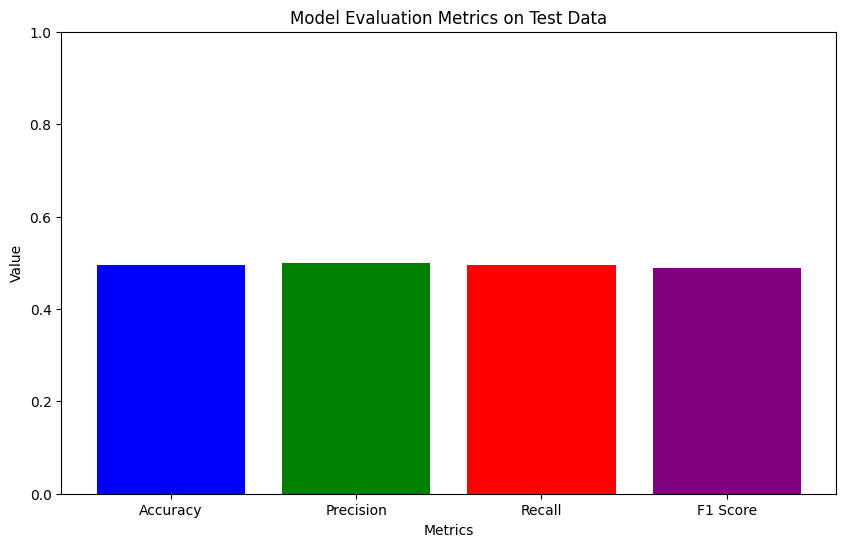

In [60]:
# Evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.bar(metrics, [accuracy_score(train_test_split_data['test']['answer'], y_pred), precision_score(train_test_split_data['test']['answer'], y_pred, average='weighted'), recall_score(train_test_split_data['test']['answer'], y_pred, average='weighted'), f1_score(train_test_split_data['test']['answer'], y_pred, average='weighted')], color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Model Evaluation Metrics on Test Data')
plt.ylim(0, 1)  # Set y-axis range to [0, 1] for accuracy and F1 score
plt.show()
